# **Waze Project**
**Course 6 - The nuts and bolts of machine learning**

# **Course 6 End-of-Course Project: Build a machine learning model**

**Part 1:** Model Building and Evaluation

**Part 2:** Interpreting Model Results

# **Build a machine learning model**


### **Imports and data loading**

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance
import pickle

In [2]:
df = pd.read_csv('dataset_encoded_features.csv')

In [3]:
df.head()

,Unnamed: 0.1,Unnamed: 0,ID,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,km_per_driving_day,percent_sessions_in_last_month,drives_per_driving_day,total_sessions_per_day,km_per_drive,is_churned,device_Android,device_iPhone
0,0,0,0,243,200,296.748273,2276,208,0,2628.845068,1985.775061,28,19,138.360267,0.95,10.526316,0.130381,13.144225,0,1,0
1,1,1,1,133,107,326.896596,1225,19,64,8898.716275,3160.472914,13,11,1246.901868,0.41,9.727273,0.266854,83.165573,0,0,1
2,2,2,2,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,382.393602,0.84,11.875000,0.051121,32.201567,0,1,0
3,3,3,3,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,304.530374,0.72,13.333333,4.505948,22.839778,0,0,1
4,4,4,4,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,219.455667,0.50,3.777778,0.107713,58.091206,0,1,0


### **Feature selection**

Tree-based models can handle multicollinearity, so the only feature that can be cut is `ID`, since it doesn't contain any information relevant to churn.

In [74]:
df.drop(columns=["ID", "Unnamed: 0.1", "Unnamed: 0"], inplace=True)
df.head()

,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,km_per_driving_day,percent_sessions_in_last_month,drives_per_driving_day,total_sessions_per_day,km_per_drive,is_churned,device_Android,device_iPhone
0,243,200,296.748273,2276,208,0,2628.845068,1985.775061,28,19,138.360267,0.95,10.526316,0.130381,13.144225,0,1,0
1,133,107,326.896596,1225,19,64,8898.716275,3160.472914,13,11,1246.901868,0.41,9.727273,0.266854,83.165573,0,0,1
2,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,382.393602,0.84,11.875000,0.051121,32.201567,0,1,0
3,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,304.530374,0.72,13.333333,4.505948,22.839778,0,0,1
4,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,219.455667,0.50,3.777778,0.107713,58.091206,0,1,0


### **Modeling workflow and model selection process**

### **Split the data**

In [9]:
X = df.copy().drop(columns=["is_churned"])
y = df["is_churned"]
X_, X_test, y_, y_test = train_test_split(X, y, stratify=y,
                                              test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_, y_, stratify=y_,
                                                  test_size=0.25, random_state=42)

In [7]:
print(y_train.shape, y_test.shape, y_val.shape)

(7938,) (2646,) (2646,)


### **Modeling**

In [67]:
rf = RandomForestClassifier(random_state=2)
cv_params = {
    'max_depth': [3, 5, 10, 15, None],
    'max_features': [1.0],
    'max_samples': [1.0],
    'min_samples_leaf': [1, 2],
    'min_samples_split': [2],
    'n_estimators': [100, 150, 300],
}

scoring = ["accuracy", "f1", "precision", "recall"]
rf_cv = GridSearchCV(estimator=rf, param_grid=cv_params, scoring=scoring, cv=5, refit="recall")

In [68]:
%%time
rf_cv.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

KeyboardInterrupt: 

In [21]:
rf_cv.best_score_

0.11086784201175344

Examine the best combination of hyperparameters.

In [22]:
rf_cv.best_params_

{'max_depth': None,
 'max_features': 1.0,
 'max_samples': 1.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100}

Use the `make_results()` function to output all of the scores of your model. Note that the function accepts three arguments.

In [23]:
def make_results(model_name, model_object, metric):
    '''
    Arguments:
        model_name (string): what you want the model to be called in the output table
        model_object: a fit GridSearchCV object
        metric (string): precision, recall, f1, or accuracy

    Returns a pandas df with the F1, recall, precision, and accuracy scores
    for the model with the best mean 'metric' score across all validation folds.
    '''

    metric_dict = {'precision': 'mean_test_precision',
                   'recall': 'mean_test_recall',
                   'f1': 'mean_test_f1',
                   'accuracy': 'mean_test_accuracy',
                   }

    cv_results = pd.DataFrame(model_object.cv_results_)
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy],
                          },
                         )

    return table

In [25]:
results = make_results('Random Forest: train', rf_cv, 'recall')
results

,model,precision,recall,F1,accuracy
0,Random Forest: train,0.445412,0.110868,0.177012,0.824389


The results aren't particularly good. Most of the metrics, aside from accuracy, are pretty low

#### **XGBoost**

In [32]:
xgb = XGBClassifier(objective='binary:logistic', random_state=912)
cv_params = {
    'max_depth': [3, 5, 6, 12],
    'min_child_weight': [3, 5],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 150, 200, 300]
}
scoring = ["accuracy", "f1", "precision", "recall"]
xgb_cv = GridSearchCV(estimator=xgb, param_grid=cv_params, scoring=scoring, cv=5, refit="recall")

In [33]:
%%time
xgb_cv.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

CPU times: user 6min 59s, sys: 2min 43s, total: 9min 42s
Wall time: 1min 18s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=912, ...),
             param_grid={'learning_rate': [0.01, 0.1],
                         'max_depth': [3, 5, 6, 12], 'min_child_weight': [3, 5],
                         'n_estimators': [100, 150, 200, 300]},
             refit='recall', scoring=['accuracy', 'f1', 'precision', 'recall'])

In [34]:
xgb_cv.best_score_

0.1537406040727074

In [35]:
xgb_cv.best_params_

{'learning_rate': 0.1,
 'max_depth': 12,
 'min_child_weight': 5,
 'n_estimators': 300}

Use the `make_results()` function to output all of the scores of your model. Note that the function accepts three arguments.

In [36]:
xgb_cv_results = make_results('XGB: train', xgb_cv, 'recall')
results = pd.concat([results, xgb_cv_results], axis=0)
results

,model,precision,recall,F1,accuracy
0,Random Forest: train,0.445412,0.110868,0.177012,0.824389
0,XGB: train,0.387709,0.153741,0.219431,0.813427


This model fit the data better than the random forest model. The recall score is 4% larger than the random forest model, so is F1, precision is 6% lower, while accuracy remains similar

### **Model selection**

#### **Random forest**

In [37]:
rf_val_prdictions = rf_cv.predict(X_val)

In [38]:
def get_test_scores(model_name, preds, y_test_data):
    '''
    Generate a table of test scores.

    In:
        model_name (string): Your choice: how the model will be named in the output table
        preds: numpy array of test predictions
        y_test_data: numpy array of y_test data

    Out:
        table: a pandas df of precision, recall, f1, and accuracy scores for your model
    '''
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy]
                          })

    return table

In [39]:
rf_val_df = get_test_scores("RF cv: validation", rf_val_prdictions, y_val)
results = pd.concat([results, rf_val_df], axis=0)
results

,model,precision,recall,F1,accuracy
0,Random Forest: train,0.445412,0.110868,0.177012,0.824389
0,XGB: train,0.387709,0.153741,0.219431,0.813427
0,RF cv: validation,0.491803,0.133038,0.209424,0.828798


#### **XGBoost**

In [40]:
xgb_val_predictions = xgb_cv.predict(X_val)

xgb_val_df = get_test_scores("XGB cv: validation", xgb_val_predictions, y_val)
results = pd.concat([results, xgb_val_df], axis=0)
results

,model,precision,recall,F1,accuracy
0,Random Forest: train,0.445412,0.110868,0.177012,0.824389
0,XGB: train,0.387709,0.153741,0.219431,0.813427
0,RF cv: validation,0.491803,0.133038,0.209424,0.828798
0,XGB cv: validation,0.430168,0.170732,0.244444,0.820106


The XGBoost model's validation scores are mostly higher that those of RF. It is still the clear champion.

### **Use champion model to predict on test data**


In [41]:
xgb_test_predictions = xgb_cv.predict(X_test)
xgb_test_df = get_test_scores("XGB cv: test", xgb_test_predictions, y_test)
results = pd.concat([results, xgb_test_df], axis=0)
results

,model,precision,recall,F1,accuracy
0,Random Forest: train,0.445412,0.110868,0.177012,0.824389
0,XGB: train,0.387709,0.153741,0.219431,0.813427
0,RF cv: validation,0.491803,0.133038,0.209424,0.828798
0,XGB cv: validation,0.430168,0.170732,0.244444,0.820106
0,XGB cv: test,0.421053,0.159645,0.231511,0.819350


### **Confusion matrix**

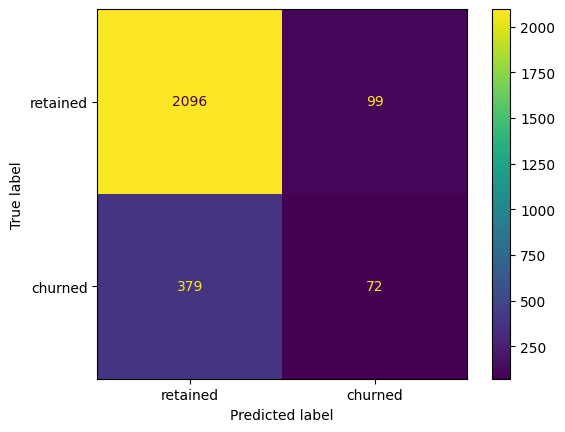

In [42]:
cm = confusion_matrix(y_test, xgb_test_predictions, labels=xgb_cv.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=['retained', 'churned'])
disp.plot()

In [82]:
target_labels = ['retained', 'churned']
print(classification_report(y_test, xgb_test_predictions, target_names=target_labels))

              precision    recall  f1-score   support

    retained       0.85      0.95      0.90      2195
     churned       0.42      0.16      0.23       451

    accuracy                           0.82      2646
   macro avg       0.63      0.56      0.56      2646
weighted avg       0.77      0.82      0.78      2646



The model predicted four times as many false negatives than it did false positives, and it correctly identified only 16% of the users who actually churned.

### **Feature importance**

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

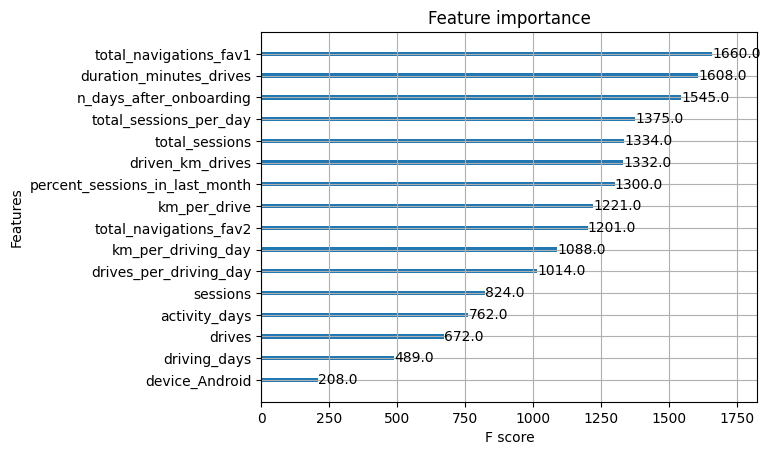

In [43]:
plot_importance(xgb_cv.best_estimator_)

The XGBoost model made more use of many of the features than did the logistic regression model from the previous course, which weighted a single feature (`activity_days`) very heavily in its final prediction.

### **Survival Random Forest**

In [3]:
from sksurv.datasets import load_gbsg2
from sksurv.preprocessing import OneHotEncoder
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored

In [4]:
df = pd.read_csv('waze_dataset.csv').dropna()
y = pd.concat([df['label'].map({'retained' :False, 'churned':True}).astype(bool),df['sessions'].astype(float)],axis=1)
dtype = [('event', bool), ('time', float)]
y=np.array(list(zip(df['label'].map({'retained' :False, 'churned':True}).astype(bool),df['sessions'].astype(float))),dtype=dtype)
X = df.drop(columns=['label','sessions','ID','device','drives','total_sessions'])
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.25, random_state=45)

In [5]:
random_state = 20
rsf = RandomSurvivalForest(
    n_estimators=100, min_samples_split=15, min_samples_leaf=10, n_jobs=-1, random_state=random_state
)
rsf.fit(X_train, y_train)

RandomSurvivalForest(min_samples_leaf=10, min_samples_split=15, n_jobs=-1,
                     random_state=20)

In [6]:
event_indicator = y_val['event']
event_time = y_val['time']
prediction = rsf.predict(X_val)
result = concordance_index_censored(event_indicator, event_time, prediction)
print(result)

(0.7149312979347503, 776775, 309728, 0, 11088)


We see Concordance_index  0.71, that is pretty high result

C:\Users\Acer\anaconda3\envs\Nastya_data_analysis\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 0, 'risk')

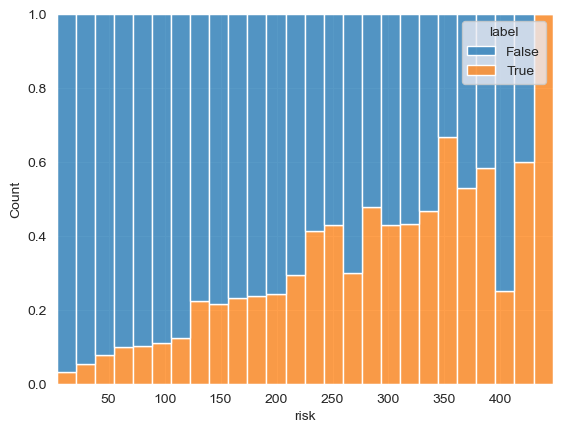

In [7]:
result_df = pd.DataFrame({'event_time':event_time,'prediction':prediction,'label':event_indicator})
ax = plt.subplot(111)
sns.histplot(result_df, hue='label',x='prediction',multiple='fill',ax=ax)
ax.set_xlabel("risk")

C:\Users\Acer\anaconda3\envs\Nastya_data_analysis\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='prediction', ylabel='Count'>

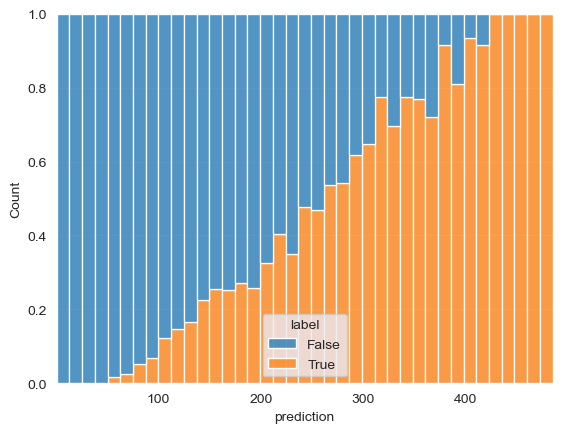

In [8]:
prediction = rsf.predict(X_train)
result_df = pd.DataFrame({'event_time':y_train['time'],'prediction':prediction,'label':y_train['event']})
sns.histplot(result_df, hue='label',x='prediction',multiple='fill')

In [9]:
from sklearn.inspection import permutation_importance
perm_import = permutation_importance(rsf, X_val, y_val, n_repeats=15, random_state=random_state)
pd.DataFrame(
    {
        k: perm_import[k]
        for k in (
        "importances_mean",
        "importances_std",
    )
    },
    index=X_val.columns,
).sort_values(by="importances_mean", ascending=False)

,importances_mean,importances_std
activity_days,0.097556,0.009559
driving_days,0.025257,0.006120
n_days_after_onboarding,0.024226,0.005721
duration_minutes_drives,0.003918,0.001922
total_navigations_fav2,0.000669,0.001539
driven_km_drives,0.000584,0.001709
total_navigations_fav1,-0.000489,0.003257


In [10]:
prediction = rsf.predict(X_val)
y_true = np.array(y_val['event'])  # True labels
y_pred = prediction>280  # Predicted labels

# Convert boolean arrays to integer type
y_true_int = y_true.astype(int)
y_pred_int = y_pred.astype(int)

# Generate confusion matrix
cm = confusion_matrix(y_true_int, y_pred_int)
print(classification_report(y_true_int, y_pred_int))
print(cm)
print(y_true.sum())

              precision    recall  f1-score   support

           0       0.85      0.96      0.90      2953
           1       0.48      0.19      0.27       622

    accuracy                           0.82      3575
   macro avg       0.67      0.57      0.59      3575
weighted avg       0.78      0.82      0.79      3575

[[2826  127]
 [ 504  118]]
622


In [ ]:
surv = rsf.predict_survival_function(X_val, return_array=True)

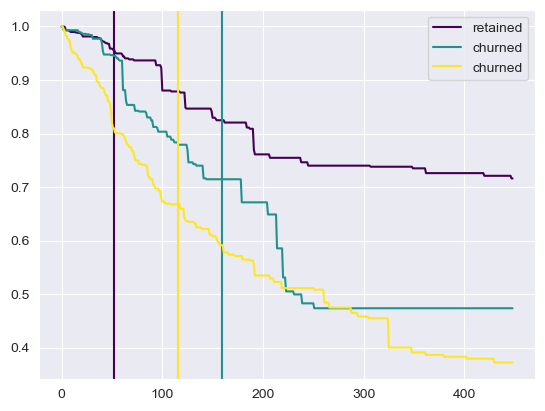

In [151]:
inverse_map= {False:'retained',True:'churned'}
values = [29,150,3430]
colormap = plt.cm.viridis
color_list = colormap(np.linspace(0, 1, len(values)))
for idx, val in enumerate(values):
    plt.plot(np.arange(len(rsf.unique_times_)),surv[val,:],label=f'{inverse_map[y_val[val][0]]}',color=color_list[idx])
    plt.axvline(y_val[val][1],color=color_list[idx])
plt.legend()

C:\Users\Acer\AppData\Local\Temp\ipykernel_23728\3811567503.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  prob[idx] = surv[i,int(timepoint[idx])]
C:\Users\Acer\anaconda3\envs\Nastya_data_analysis\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Acer\AppData\Local\Temp\ipykernel_23728\3811567503.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  prob[idx] = surv[i,int(timepoint[idx])]
C:\Users\Acer\anaconda3\envs\Nastya_data_analysis\L

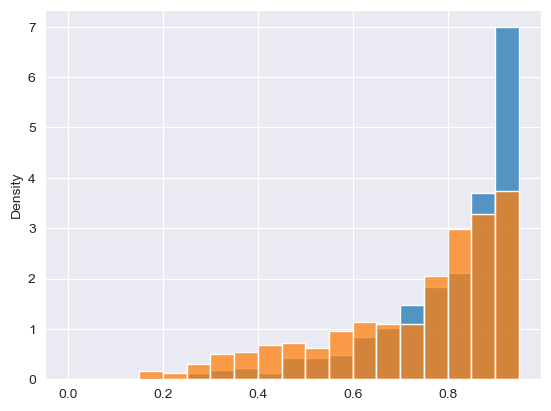

In [152]:
bins= np.arange(20)*0.05
for label in range(2):
    times=y_val[y_val['event']==label]['time']
    timepoint = np.zeros(len(times))
    for i in range(len(times)):
        timepoint[i] = np.argmin(np.abs(rsf.unique_times_-times[i]))
    prob = np.zeros(len(times))
    for idx,i in enumerate(np.argwhere(y_val['event']==label)):
        prob[idx] = surv[i,int(timepoint[idx])]
    sns.histplot(prob,bins=bins,stat= 'density',label = 'retained')

### **Conclusion**

Both models demonstrated low performance and should not be chosen for production. Still, it could be used to guide further exploratory efforts.
The features chosen by the XGBoost model are very different from the features chosen by the logistic regression model. Here, the number of navigations to a favourite place, the duration of drives, and the number of days after onboarding are the top-3 most important. The engineered features appear in the middle of the graph, being slightly less important according to the model.

Even though tree-based models are not sensitive to outliers, points made in the previous parts still stand, and answers & data are needed to imporove model predictions. As a reminder, the points are:
* errors present in the data (physically impossible values)
* no clear definition on how "churned" is assigned
* the need for more granular data